# Assignment 2

In [1]:
import urllib.request
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from networkx.algorithms import bipartite
import random
import math
import json
import re
from io import BytesIO
import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from scipy.stats import spearmanr, pearsonr
from scipy import stats
from fa2_modified import ForceAtlas2

In [2]:
def load_online_gml(url):
    with urllib.request.urlopen(url) as response:
        online_gml = BytesIO(response.read())
    net = nx.read_gml(online_gml)
    return net
    
net_url = "https://www.student.dtu.dk/~s230357/02805/assignment1/rock_performers_network.gml"

rp_dg_net = load_online_gml(net_url)
rp_ug_net = nx.Graph(rp_dg_net)

# Part 1: Analyze the network



In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G_performers = load_online_gml(net_url)

self_loops = list(nx.selfloop_edges(G_performers))
G_performers.remove_edges_from(self_loops)

print(f"Removed {len(self_loops)} self-loops.")

print(f"Initial graph: {G_performers.number_of_nodes()} nodes, {G_performers.number_of_edges()} edges")

isolated_nodes = [n for n in G_performers.nodes if G_performers.in_degree(n) == 0 and G_performers.out_degree(n) == 0]
G_performers.remove_nodes_from(isolated_nodes)

print(f"After removing isolated nodes: {G_performers.number_of_nodes()} nodes, {G_performers.number_of_edges()} edges")

largest_cc = max(nx.weakly_connected_components(G_performers), key=len)
G_largest = G_performers.subgraph(largest_cc).copy()

print(f"Largest component: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")

Removed 0 self-loops.
Initial graph: 484 nodes, 7217 edges
After removing isolated nodes: 484 nodes, 7217 edges
Largest component: 484 nodes, 7217 edges


## 1. Degree distribution


--- In-Degree ---
Mean:   14.91
Median: 10.00
Mode:   3
StdDev: 16.81

--- Out-Degree ---
Mean:   14.91
Median: 12.00
Mode:   9
StdDev: 10.57

--- Total Degree ---
Mean:   29.82
Median: 23.00
Mode:   9
StdDev: 24.70


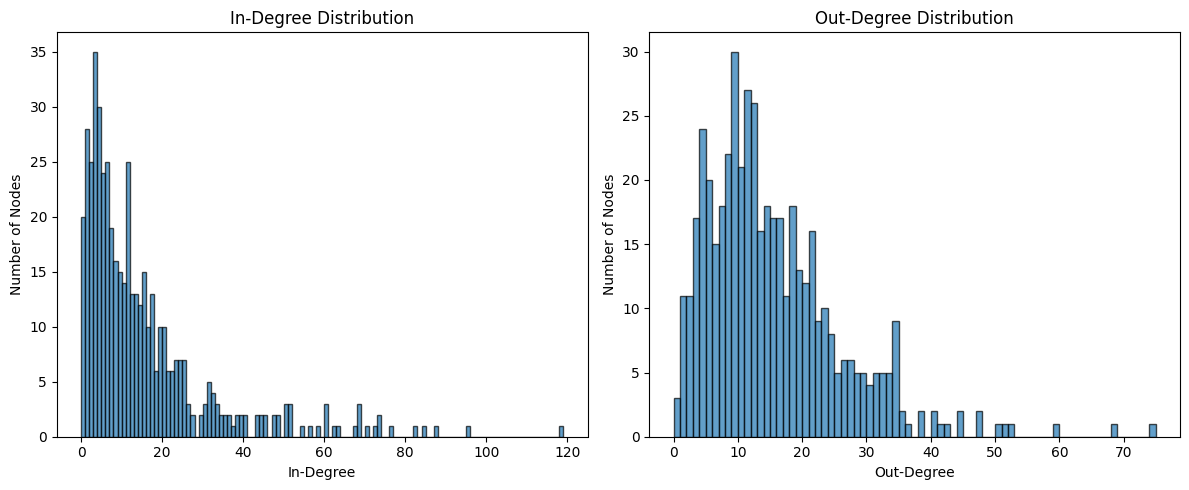

In [4]:
# ---- DEGREE DISTRIBUTIONS ----

# Get degree sequences
in_degrees = [deg for _, deg in G_largest.in_degree()]
out_degrees = [deg for _, deg in G_largest.out_degree()]
total_degrees = [deg for _, deg in G_largest.degree()]

# ---- Compute basic statistics ----
def summarize_degrees(degrees, label):
    mean = np.mean(degrees)
    median = np.median(degrees)
    mode = stats.mode(degrees, keepdims=True)[0][0]
    stdev = np.std(degrees)

    print(f"\n--- {label} ---")
    print(f"Mean:   {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Mode:   {mode}")
    print(f"StdDev: {stdev:.2f}")

# Display summary stats
summarize_degrees(in_degrees, "In-Degree")
summarize_degrees(out_degrees, "Out-Degree")
summarize_degrees(total_degrees, "Total Degree")

# ---- Plot histograms ----
plt.figure(figsize=(12, 5))

# In-degree distribution with same
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(0, max(in_degrees)+2), edgecolor='black', alpha=0.7)
plt.title("In-Degree Distribution")
plt.xlabel("In-Degree")
plt.ylabel("Number of Nodes")

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(0, max(out_degrees)+2), edgecolor='black', alpha=0.7)
plt.title("Out-Degree Distribution")
plt.xlabel("Out-Degree")
plt.ylabel("Number of Nodes")

plt.tight_layout()
plt.show()


According to the graphs and statistics, artists/bands have a higher median for out-degree, but in-degree has more extreme values, with the highest value reaching almost 120. The explanation behind this behavior may be that the average band can have many influences, very few bands reach the threshold of inspiring multiple other bands. The ones that do break this threshold however, have a huge influence thus explaining the more extreme values. This explains why so many genre defining bands such as The Beatles, Nirvana, Black Sabbath, Bob Dylan, and Metallica have higher in-degrees.

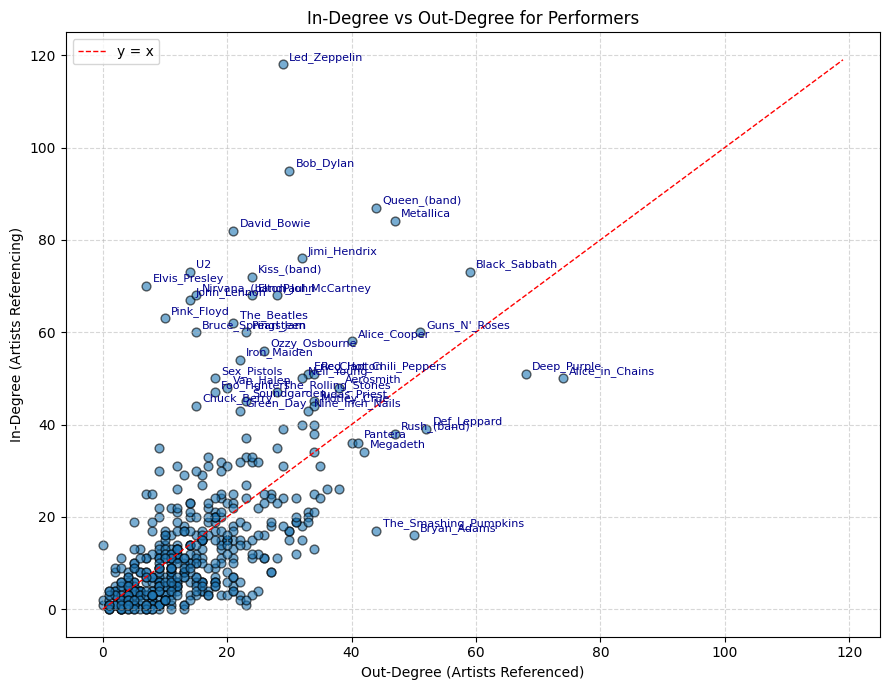

In [5]:
# Extract degrees
in_degrees = dict(G_largest.in_degree())
out_degrees = dict(G_largest.out_degree())

# Create aligned lists for plotting
nodes = list(G_largest.nodes())
x_out = [out_degrees.get(n, 0) for n in nodes]
y_in = [in_degrees.get(n, 0) for n in nodes]

plt.figure(figsize=(9, 7))
plt.scatter(x_out, y_in, alpha=0.6, s=40, edgecolor='k')

plt.title("In-Degree vs Out-Degree for Performers")
plt.xlabel("Out-Degree (Artists Referenced)")
plt.ylabel("In-Degree (Artists Referencing)")
plt.grid(True, linestyle="--", alpha=0.5)

# Reference line y=x
max_deg = max(max(x_out), max(y_in)) + 1
plt.plot([0, max_deg], [0, max_deg], 'r--', lw=1, label='y = x')
plt.legend()

# ---- Label points with high degree ----
THRESHOLD = 40  # label if either degree > 50
for node, x, y in zip(nodes, x_out, y_in):
    if x > THRESHOLD or y > THRESHOLD:
        plt.text(x + 1, y + 1, node, fontsize=8, color='darkblue')

plt.tight_layout()
plt.show()

## 2. Centrality and Assortativity

In [6]:
# ---------- Compute degree-based measures ----------
in_deg = dict(G_largest.in_degree())
out_deg = dict(G_largest.out_degree())
total_deg = dict(G_largest.degree())

def print_top_list(name, items, include_vals=None, top_n=5):
    print(f"\n=== Top {top_n} by {name} ===")
    header = f"{'Rank':<4} {'Node':<30} {name:<12}"
    if include_vals:
        for k in include_vals:
            header += f" {k:<12}"
    print(header)
    print("-"*len(header))
    for i, (node, score) in enumerate(items[:top_n], start=1):
        line = f"{i:<4} {node:<30} {score:<12.4g}"
        if include_vals:
            for k, d in include_vals.items():
                line += f" {d.get(node, 0):<12.4g}"
        wc = G_largest.nodes[node].get("word_count", None)
        if wc is not None:
            line += f" {wc:<12d}"
        print(line)

top_total = sorted(total_deg.items(), key=lambda x: x[1], reverse=True)
print_top_list("Total Degree", top_total, include_vals={"In-Degree": in_deg, "Out-Degree": out_deg}, top_n=10)

# ---------- Betweenness ----------
print("\nCalculating betweenness centrality ...")
bw = nx.betweenness_centrality(G_largest, normalized=True)
top_bw = sorted(bw.items(), key=lambda x: x[1], reverse=True)
print_top_list("Betweenness", top_bw, include_vals={"Degree": total_deg}, top_n=10)

# ---------- Eigenvector ----------
print("\nCalculating eigenvector centralities ...")
try:
    eig_out = nx.eigenvector_centrality_numpy(G_largest)
except Exception:
    eig_out = nx.eigenvector_centrality(G_largest, max_iter=5000)

try:
    eig_in = nx.eigenvector_centrality_numpy(G_largest.reverse())
except Exception:
    eig_in = nx.eigenvector_centrality(G_largest.reverse(), max_iter=5000)

top_eig_in = sorted(eig_in.items(), key=lambda x: x[1], reverse=True)
top_eig_out = sorted(eig_out.items(), key=lambda x: x[1], reverse=True)
print_top_list("Eigenvector (in)", top_eig_in, include_vals={"Total-Deg": total_deg}, top_n=10)
print_top_list("Eigenvector (out)", top_eig_out, include_vals={"Total-Deg": total_deg}, top_n=10)

# ---------- Correlation data ----------
deg_values = np.array([total_deg[n] for n in G_largest.nodes()])
bw_values = np.array([bw[n] for n in G_largest.nodes()])
eig_in_vals = np.array([eig_in[n] for n in G_largest.nodes()])
eig_out_vals = np.array([eig_out[n] for n in G_largest.nodes()])

# ---------- Assortativity ----------
G_und = G_largest.to_undirected()
deg_assort = nx.degree_assortativity_coefficient(G_und)
word_counts = {n: G_largest.nodes[n].get("word_count", 0) for n in G_largest.nodes()}
nx.set_node_attributes(G_und, word_counts, "word_count")
word_assort = nx.numeric_assortativity_coefficient(G_und, "word_count")
print("\nDegree assortativity:", deg_assort)
print("Word_count assortativity:", word_assort)

# ---------- Shortest path summary ----------
if nx.is_connected(G_und):
    avg_sp = nx.average_shortest_path_length(G_und)
else:
    comp = max(nx.connected_components(G_und), key=len)
    G_conn = G_und.subgraph(comp)
    avg_sp = nx.average_shortest_path_length(G_conn)
print("\nAverage shortest path (G_largest):", avg_sp)

# Compare to random ER
n = G_und.number_of_nodes()
m = G_und.number_of_edges()
p = (2*m) / (n*(n-1))
R = nx.erdos_renyi_graph(n, p, seed=42)
if not nx.is_connected(R):
    R = R.subgraph(max(nx.connected_components(R), key=len))
avg_sp_random = nx.average_shortest_path_length(R)
print("Average shortest path (random ER):", avg_sp_random)

# store for plotting sections
metrics = dict(
    G_und=G_und, total_deg=total_deg, bw=bw, eig_in=eig_in,
    deg_values=deg_values, bw_values=bw_values, eig_in_vals=eig_in_vals, eig_out_vals=eig_out_vals,
    R=R
)



=== Top 10 by Total Degree ===
Rank Node                           Total Degree In-Degree    Out-Degree  
--------------------------------------------------------------------------
1    Led_Zeppelin                   147          118          29          
2    Black_Sabbath                  132          73           59          
3    Metallica                      131          84           47          
4    Queen_(band)                   131          87           44          
5    Bob_Dylan                      125          95           30          
6    Alice_in_Chains                124          50           74          
7    Deep_Purple                    119          51           68          
8    Guns_N'_Roses                  111          60           51          
9    Jimi_Hendrix                   108          76           32          
10   David_Bowie                    103          82           21          

Calculating betweenness centrality ...

=== Top 10 by Betweenness =

C:\Users\Think\AppData\Local\Programs\Python\Python313\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


Ranking the bands by various metrics leads to some interesting results. Ranking by total degree, I would interpret this as a general metric of popularity, innovation, and influence. We see Led Zeppelin, Black Sabbath, and Bob Dylan as examples who have all had a huge impact on other artists. When ranking by betweeness however, you get some interesting bands such as Alice in Chains that, like the name suggests, are a band somewhat in between the metal/rock genre. I could see how many paths of connectivity could flow through Alice in Chains from one band to another. The eigen value in ranking also brings up Alice in Chains, reflecting the idea that many other popular bands have some sort of link to them. An interesting detail is that the top 10 for this ranking seem to be more on the heavy metal side of things, perhaps due to how similar the bands' target audience was at the time for this genre of music. As for eigenvalue out, the top 10 ranking reinforces the fact that these artists have connections to bands that are also very famous. The Beatles members showing up here is also a sign of this, as they were so experimental that wikipedia is bound to have information that connects them to many other popular bands.

The degree assortativity indicates that connections between big and small artists are quite random. There doesn't seem to be a strong preference for big artists to only be linked with other big artists. Word count did have a higher value however, which makes sense given the nature of wikipedia articles.

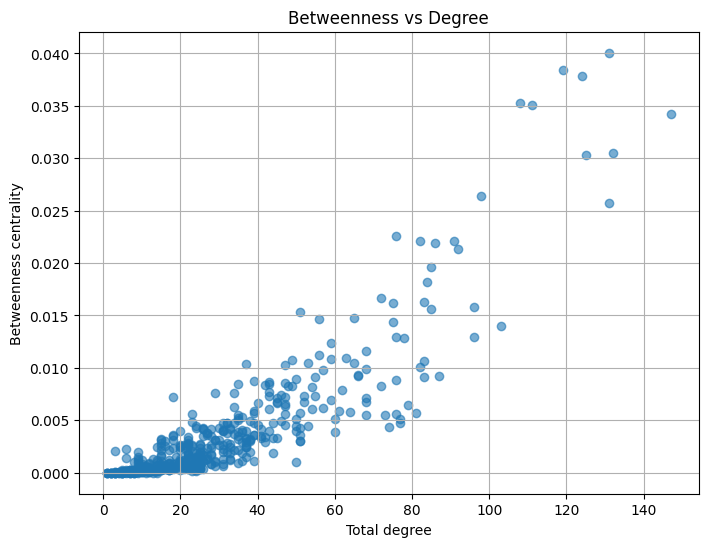

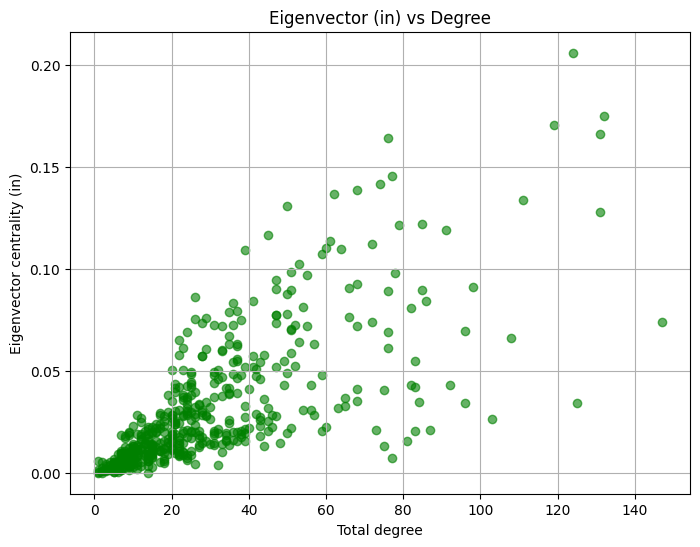

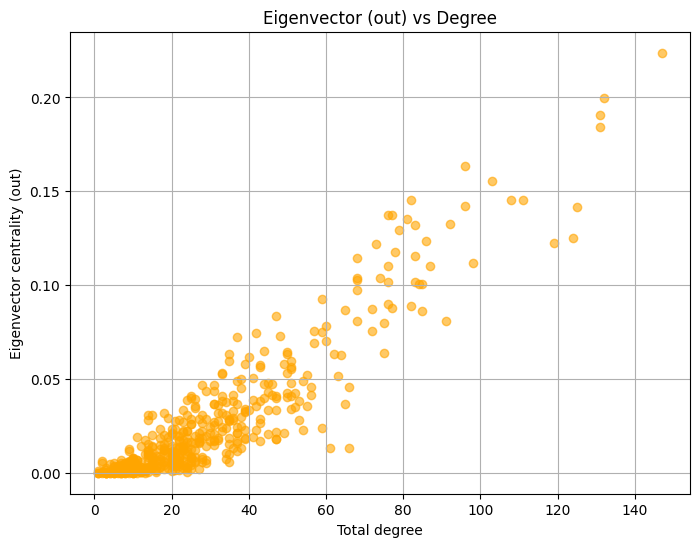

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(metrics["deg_values"], metrics["bw_values"], alpha=0.6)
plt.xlabel("Total degree")
plt.ylabel("Betweenness centrality")
plt.title("Betweenness vs Degree")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(metrics["deg_values"], metrics["eig_in_vals"], alpha=0.6, color='green')
plt.xlabel("Total degree")
plt.ylabel("Eigenvector centrality (in)")
plt.title("Eigenvector (in) vs Degree")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(metrics["deg_values"], metrics["eig_out_vals"], alpha=0.6, color='orange')
plt.xlabel("Total degree")
plt.ylabel("Eigenvector centrality (out)")
plt.title("Eigenvector (out) vs Degree")
plt.grid(True)
plt.show()


The biggest thing that I notice when comparing these graphs is that eig-out and betweeness follow a similar trend, wheareas eig-in deviates from the pattern. This makes sense, because eig-out means that the band connects to highly influential nodes, which is similar to the definition for betweeness.

## 3. Backbone Analysis

100%|██████████| 2000/2000 [00:13<00:00, 151.20it/s]


BarnesHut Approximation  took  1.09  seconds
Repulsion forces  took  11.14  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.41  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


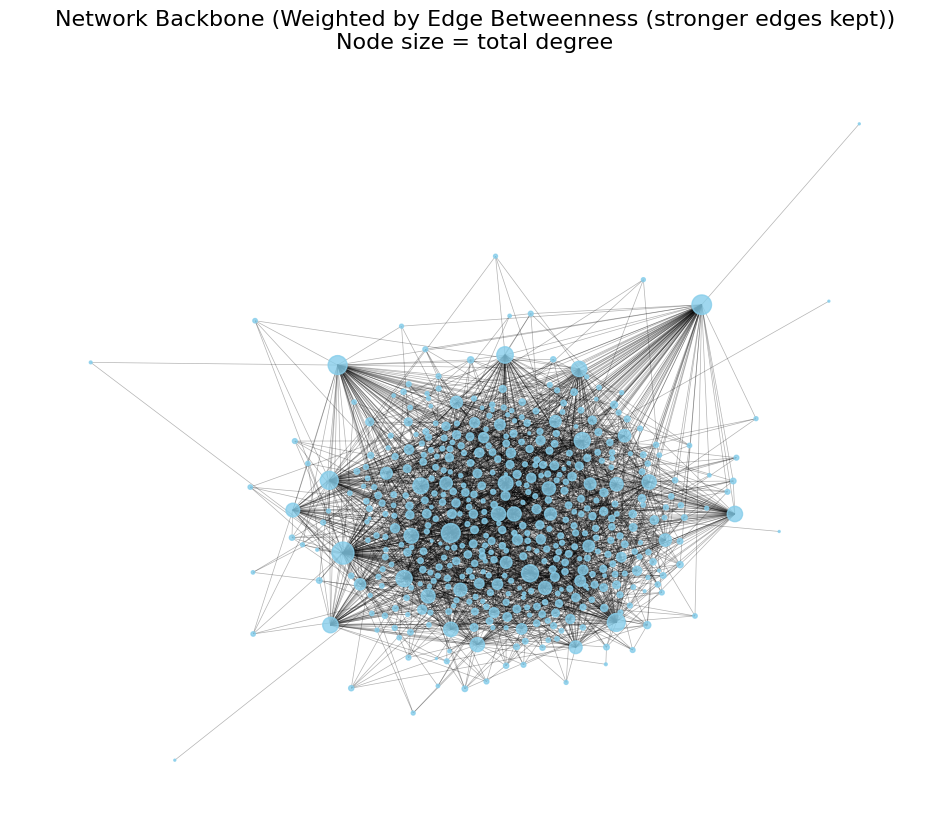

100%|██████████| 2000/2000 [00:11<00:00, 180.93it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  9.08  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.41  seconds
AdjustSpeedAndApplyForces step  took  0.35  seconds


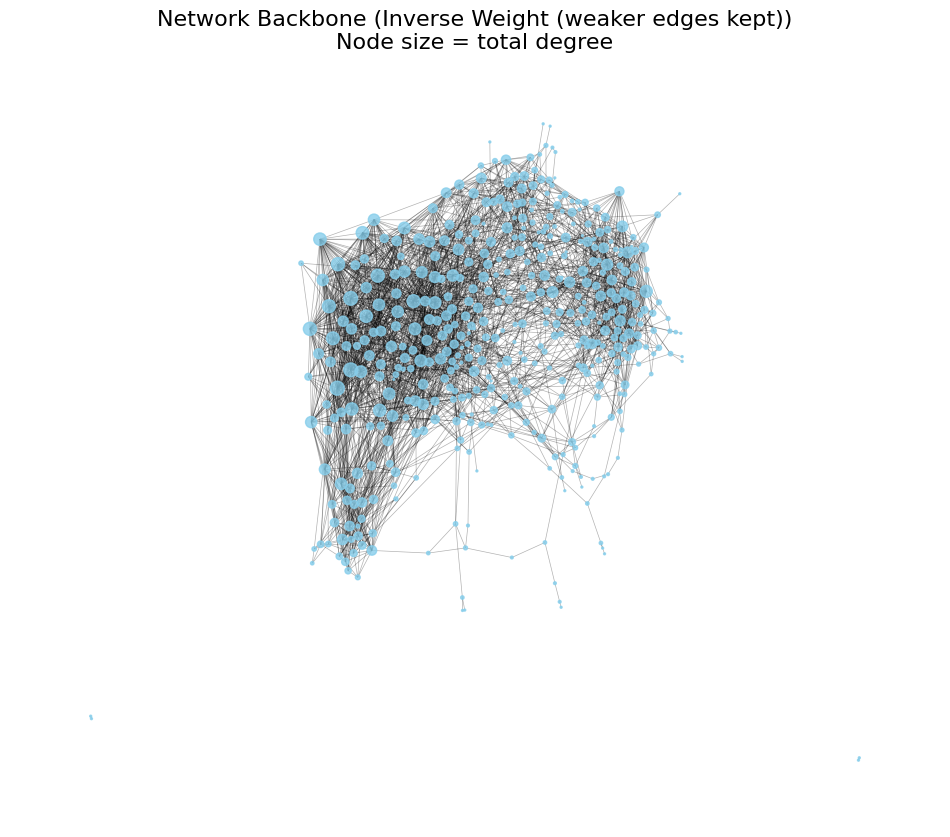

In [8]:
# ---- 2. Compute edge betweenness centrality ----
edge_btw = nx.edge_betweenness_centrality(G_und)

# ---- 3. Weighted Network 1 ----
# Normalize between 1 and 100
min_val, max_val = min(edge_btw.values()), max(edge_btw.values())
weights1 = {edge: 1 + 99 * (val - min_val) / (max_val - min_val) for edge, val in edge_btw.items()}

# Copy graph and assign weights
G_weighted1 = G_und.copy()
nx.set_edge_attributes(G_weighted1, values=weights1, name='weight')

# ---- 4. Weighted Network 2 ----
# Inverse of Weighted Network 1
weights2 = {edge: 1 / weight for edge, weight in weights1.items()}
G_weighted2 = G_und.copy()
nx.set_edge_attributes(G_weighted2, values=weights2, name='weight')


# ---- 5. Backbone extraction function ----
def extract_backbone(G, weight='weight', percentile=50):
    """
    Extracts the backbone by keeping only the top X% strongest edges
    according to the specified edge weight.
    """
    weights = [d[2][weight] for d in G.edges(data=True)]
    threshold = np.percentile(weights, percentile)
    edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d[weight] >= threshold]
    backbone = G.edge_subgraph(edges_to_keep).copy()
    return backbone


# ---- 6. Extract backbones ----
G_bb1 = extract_backbone(G_weighted1, weight='weight', percentile=50)
G_bb2 = extract_backbone(G_weighted2, weight='weight', percentile=50)


# ---- 7. ForceAtlas2 plotting function ----
def plot_forceatlas(G, title_suffix=""):
    """
    Plots a network using the ForceAtlas2 layout.
    Node size is proportional to total degree.
    """
    G_und = G.to_undirected()
    
    # Node sizes by degree
    degrees = dict(G_und.degree())
    node_sizes = [degrees[n] * 2 for n in G_und.nodes()]
    
    # Compute ForceAtlas2 layout
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=True,
        edgeWeightInfluence=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
    )
    
    pos = forceatlas2.forceatlas2_networkx_layout(G_und, iterations=2000)
    
    # Plot
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G_und, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(G_und, pos, alpha=0.3, width=0.5)
    
    plt.title(f"Network Backbone ({title_suffix})\nNode size = total degree", fontsize=16)
    plt.axis('off')
    plt.show()


# ---- 8. Plot each backbone ----
plot_forceatlas(G_bb1, title_suffix="Weighted by Edge Betweenness (stronger edges kept)")
plot_forceatlas(G_bb2, title_suffix="Inverse Weight (weaker edges kept)")

From the defenition of the edge weights, our interpretation of what information will be exctracted from each is that the betweeness backbone will reflect connectors across artists and genres wheareas the inverse betweeness backbone will reflect a closer clustering of artists in a tight knit group. This pattern appears to be evident if we observe the two graphs. In the first one you can clearly see that some nodes, especially the big ones around the edges, have many connections to others. In the second graph however, these are less of these big connector nodes and also the is less of a spread in the size of each node, indicating a closer community here.

In [9]:
def top_nodes_with_wordcount(G, top_n=10):
    """
    Prints top nodes by degree along with their word_count.
    """
    # Create a list of tuples: (node, degree, word_count)
    node_info = [(n, d, G.nodes[n].get('word_count', 0)) for n, d in G.degree()]
    
    # Sort by degree descending
    node_info_sorted = sorted(node_info, key=lambda x: x[1], reverse=True)
    
    print(f"{'Node':<30} {'Degree':<10} {'Word Count':<10}")
    print("-"*55)
    for n, deg, wc in node_info_sorted[:top_n]:
        print(f"{n:<30} {deg:<10} {wc:<10}")

# Example usage for backbones
print("=== Backbone 1: Edge Betweenness ===")
top_nodes_with_wordcount(G_bb1, top_n=15)

print("\n=== Backbone 2: Inverse Edge Betweenness ===")
top_nodes_with_wordcount(G_bb2, top_n=15)

# If you implement HSS backbone:
# print("\n=== Backbone 3: High Salience Skeleton ===")
# top_nodes_with_wordcount(G_bb3, top_n=15)


=== Backbone 1: Edge Betweenness ===
Node                           Degree     Word Count
-------------------------------------------------------
Led_Zeppelin                   126        0         
Bob_Dylan                      99         0         
Deep_Purple                    93         0         
Queen_(band)                   93         0         
Jimi_Hendrix                   84         0         
David_Bowie                    83         0         
U2                             75         0         
Elton_John                     70         0         
Elvis_Presley                  68         0         
Guns_N'_Roses                  68         0         
The_Beatles                    65         0         
Alice_in_Chains                62         0         
Alice_Cooper                   61         0         
Bruce_Springsteen              61         0         
The_Rolling_Stones             57         0         

=== Backbone 2: Inverse Edge Betweenness ===
Node         

Upon taking a look at the top 10 artists sorted by edge weight for each of our backbone visualization techniques, the edge betweeness artist are those we have seen before in the report such as Bob Dylan, The Beatles, Led Zeppelin, but the inverse of this reflects the heavy metal side of rock very well, featuring bands such as Korn, Limp Bizkit, Iron Maiden, etc. These are bands that have a sound that can be jarring, especially for someone on the opposite spectrum of the rock genre, so the lack of connections makes sense in this regard, but within the group there is a lot of similarity and influence which has resulted in the wikipedia links forming in this way.

## 4. Visualizations

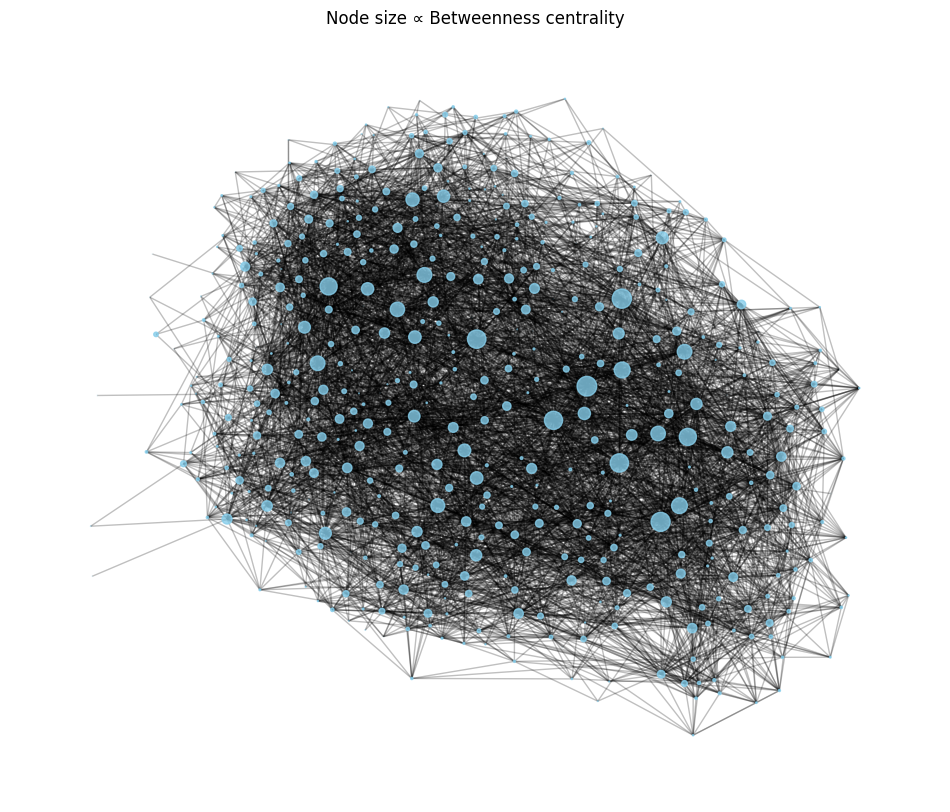

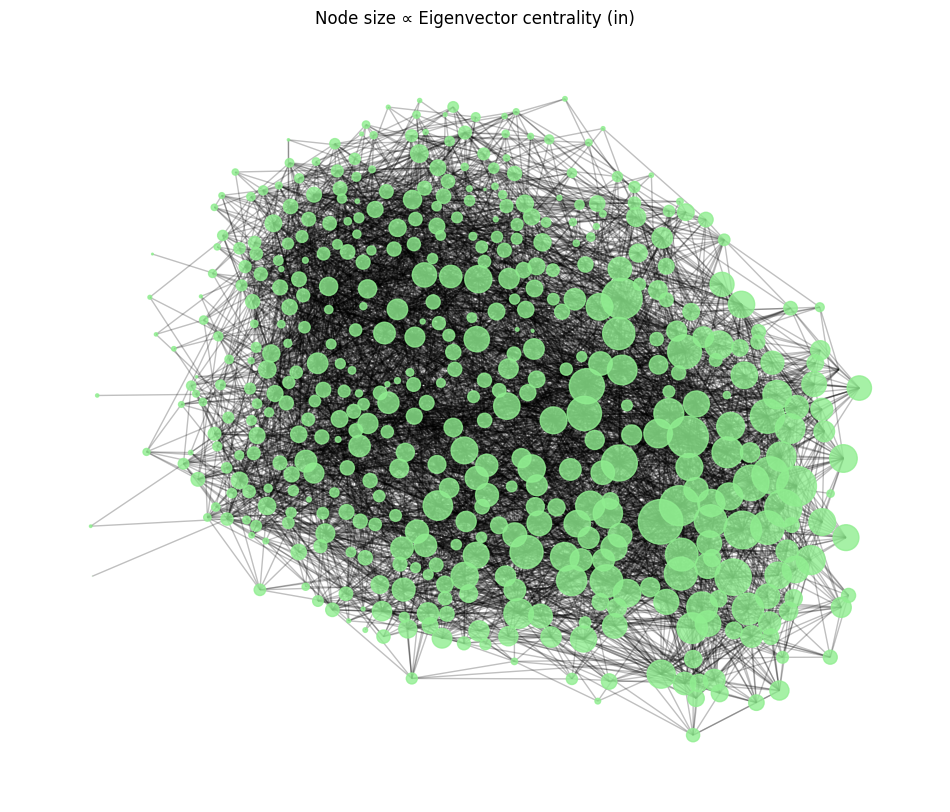

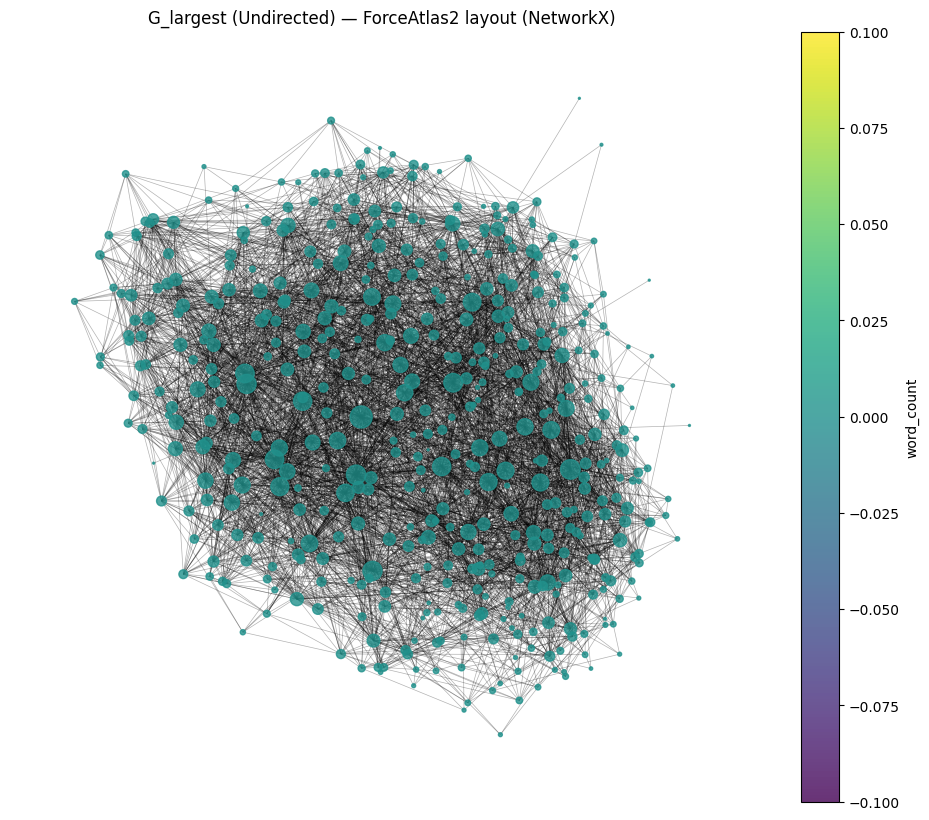

In [10]:
pos = nx.forceatlas2_layout(metrics["G_und"], max_iter=400)

# Betweenness-sized plot
node_sizes_bw = [(metrics["bw"][n] + 1e-6)*5000 for n in metrics["G_und"].nodes()]
plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(metrics["G_und"], pos, node_size=node_sizes_bw, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(metrics["G_und"], pos, alpha=0.25)
plt.title("Node size ∝ Betweenness centrality")
plt.axis('off')
plt.show()

# Eigenvector-sized plot
node_sizes_eig = [(metrics["eig_in"][n] + 1e-6)*5000 for n in metrics["G_und"].nodes()]
plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(metrics["G_und"], pos, node_size=node_sizes_eig, node_color='lightgreen', alpha=0.8)
nx.draw_networkx_edges(metrics["G_und"], pos, alpha=0.25)
plt.title("Node size ∝ Eigenvector centrality (in)")
plt.axis('off')
plt.show()

G_undirected = G_largest.to_undirected()

# ForceAtlas2 layout
pos = nx.forceatlas2_layout(G_undirected, max_iter=2000, gravity=1.0, scaling_ratio=2.0)

# Node sizes/colors
degrees = dict(G_undirected.degree())
node_sizes = [degrees[n]*2 for n in G_undirected.nodes()]
lengths = nx.get_node_attributes(G_undirected, 'word_count')
node_colors = [lengths.get(n, 0) for n in G_undirected.nodes()]

plt.figure(figsize=(12, 10))
nodes_draw = nx.draw_networkx_nodes(
    G_undirected, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='viridis',
    alpha=0.8
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, width=0.5)
plt.title("G_largest (Undirected) — ForceAtlas2 layout (NetworkX)")
plt.colorbar(nodes_draw, label="word_count")
plt.axis('off')
plt.show()


# Part 2: Genres and communities and plotting 

In [11]:
def load_online_data(url):
    with urllib.request.urlopen(url) as response:
        return response.read()

def encode_title(t):
    return urllib.parse.quote(t, safe='')

def decode_title(t):
    return urllib.parse.unquote(t)

wiki_query_history = {}

def wiki_query(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles={}".format(encode_title(title.replace(' ', '_')))
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, dataformat, title)

    if title in wiki_query_history:
        return query,wiki_query_history[title]

    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent', 'MyClient/0.1')]
    urllib.request.install_opener(opener)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read().decode('utf-8')
    
    wikijson = json.loads(wikidata)
    page_id = list(wikijson["query"]["pages"].keys())[0]
    wikitext = wikijson["query"]["pages"][page_id]["revisions"][0]["*"]
    
    wiki_query_history[title] = wikitext
    return query,wikitext

regular_title = r'(?<=[\s|\*]\[{2}).+?(?=(?:\|.+?)?\]{2})'
mapping_url = "https://www.student.dtu.dk/~s230357/02805/assignment2/genre_mapping.json"

genre_mapping = json.loads(load_online_data(mapping_url))

* Write about genres and modularity.
>
>  The idea of modularity is to identify naturally occurring communities in the network by breaking down large networks into smaller modules. Because these communities are naturally formed, their classifications may not perfectly correspond to any single genre. The modularity is a good way to characterize the community structure if there are no other labels such as genre labels.

In [12]:
def normalize_genre(genre_str):
    cleaned = genre_str.lower()
    raw_genres = re.findall(regular_title,cleaned)

    normalized_genres = []
    for raw_genre in raw_genres:
        genre = raw_genre.strip()
        
        genre = re.sub(r'\s+', ' ', genre)
        genre = genre.strip(' ,.;')
        
        if not genre or len(genre) < 2:
            continue
            
        genre_lower = genre.lower()
        if genre_lower in genre_mapping:
            normalized_genre = genre_mapping[genre_lower]
        else:
            normalized_genre = [genre_lower]
        
        normalized_genres += normalized_genre
    
    return list(set(normalized_genres))

def get_genres(title):
    query,wikitext = wiki_query(title)
    if len(re.findall(r'{{infobox ', wikitext.lower()))>0:
        m = re.search(r'\|\s*genre\s*?=(.+?)(?=\n\s*\|\s*\w)', wikitext,flags=re.DOTALL)
        if m:
            genre_text = m.group(1)

            genres = normalize_genre(genre_text)
            if len(genres) == 0:
                print("Found 0 genre: {}".format(title))
            else:
                return genres
        else:
            print("No genre: {}".format(title))
    else:
        print("No infobox: {}".format(title))
    return None

performer_genre_dict = {}
all_genres = []
for title in rp_ug_net.nodes:
    genres = get_genres(title)
    if genres is not None:
        performer_genre_dict[title] = genres
        all_genres += genres

rp_ug_net.remove_nodes_from([n for n in rp_dg_net.nodes if n not in performer_genre_dict])

No infobox: Dallas_Green_(musician)
Found 0 genre: Grateful_Dead
No infobox: Poison_(American_band)
Found 0 genre: Slayer


* Detect the communities, discuss the value of modularity in comparison to the genres.
>
>  Genre is an artificially defined, external, semantic classification. It is an attribute of a node and cannot fully represent the connection pattern of a node. However, modularity automatically identifies communities based on the connection pattern of dense connections within communities and sparse connections between communities, revealing the hidden structure within the network. This allows nodes that appear different in genre to be treated as belonging to the same group in terms of connection behavior. This means that modularity is completely independent of labels, even if the labels are incomplete or missing, it can also help to discover latent communities.

In [13]:
#louvain_communities = nx.community.louvain_communities(rp_ug_net,resolution=1)
louvain_communities = nx.community.louvain_communities(rp_ug_net,resolution=1.5)

louvain_communities = sorted(louvain_communities,key=len, reverse=True)

max_num = 10
if len(louvain_communities) > max_num:
    for community in louvain_communities[max_num:]:
        louvain_communities[max_num-1] |= community
louvain_communities = louvain_communities[0:max_num]

print("The number of communities: {}".format([len(community) for community in louvain_communities]))

The number of communities: [84, 80, 50, 46, 44, 42, 41, 28, 27, 38]


* Calculate the matrix $D$ and discuss your findings.
>
>  The more common a genre, the more communities it involves, but most genres have a clear, dominant community. Correspondingly, a single community may involve multiple common genres, and the naturally formed communities do not overlap with genre classifications. And this means that external labels cannot represent the connection patterns of real-world network nodes.

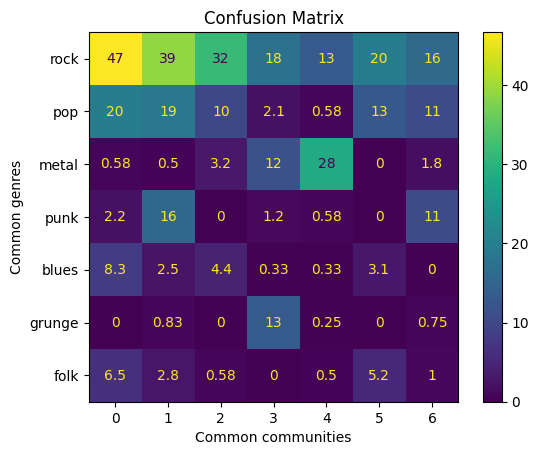

In [14]:
freq_dist = nltk.FreqDist([g for k in performer_genre_dict for g in performer_genre_dict[k]])

c = louvain_communities[0:7]
g = sorted(freq_dist,key=freq_dist.get, reverse=True)[0:len(c)]
d = np.zeros((len(g),len(c)))

for node in performer_genre_dict:
    genres = performer_genre_dict[node]
    j = None
    
    for i,community in enumerate(c):
        if node in community:
            j = i
            break
            
    if j is None:
        continue
        
    same_num = len(set(genres) & set(g))

    if same_num==0:
        continue
    
    for i,genre in enumerate(g):
        if genre in genres:
            d[i,j]+=1/same_num

disp = ConfusionMatrixDisplay(confusion_matrix=d)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Common communities')
plt.ylabel('Common genres')
plt.xticks(range(len(c)),range(0,len(c)))
plt.yticks(range(len(g)),g)
plt.show()

* Plot the communities and comment on your results.
>
>  The result of modularity exhibits a clustering-like effect, with strong structural significance within the communities, which means it reveals hidden network structures. At the same time, the larger the community, the stronger its structure and the more distinct its distribution area.

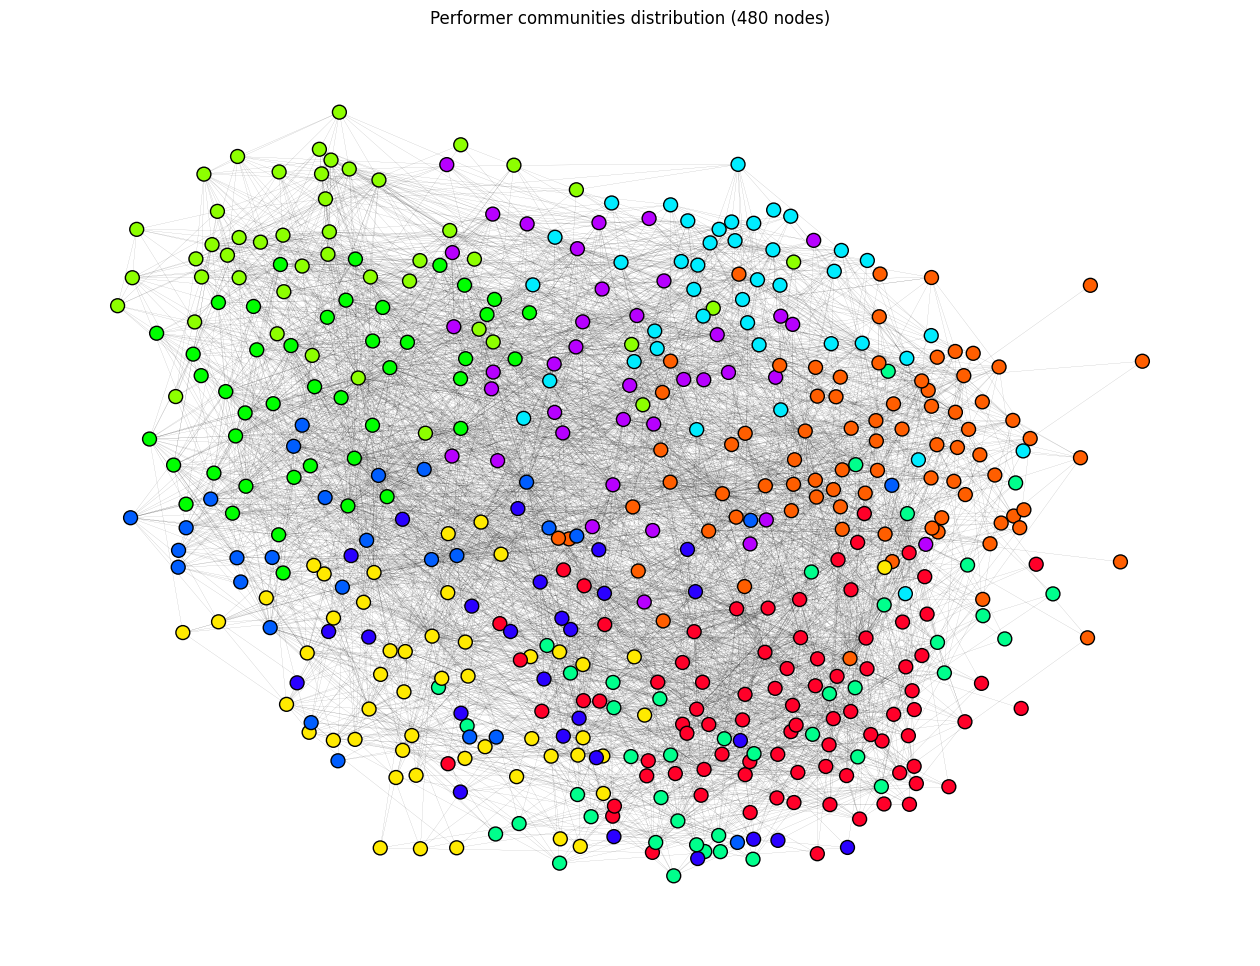

In [15]:
cmap = mpl.colormaps['gist_rainbow']

node_color_list = [cmap(n/len(louvain_communities)) for node in rp_dg_net.nodes for n,community in enumerate(louvain_communities) if node in community]

pos_init = nx.kamada_kawai_layout(rp_ug_net)
pos = nx.forceatlas2_layout(rp_ug_net,pos_init,scaling_ratio=0.9,max_iter=40)

plt.figure(figsize=(16, 12))
plt.title('Performer communities distribution ({} nodes)'.format(len(rp_ug_net.nodes)))
nx.draw(rp_ug_net, pos, node_size=100, node_color=node_color_list, width=0.05, edgecolors="#000000")
plt.show()

# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>
> TF is term frequency, it is the relative frequency of term within document. The term frequency can find frequently occurring words in the document. However, it can not distinguish between high-frequency words that are keywords or meaningless words, such as stop words.
>
> IDF is inverse document frequency, it means the frequency of a word in different documents. It's idea is a word has poor ability to distinguish documents if it in a lot of documents.
>
> A word that can represent a document needs high term frequency and high inverse document frequency, compared with meaningless words which have low inverse document frequency. Based on these concepts, The product of term frequency and inverse document frequency， i.e., TF-IDF value, can help to find the high-frequency keywords in a document. So
>
> So we can find words that have high TF-IDF value in genres and communities as keywords to help the understanding the similarities and difference between them.
>
* Calculate and visualize TF-IDF for the genres and communities.

In [16]:
lemmatizer = WordNetLemmatizer()
def nomarralize_words(text):
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\<ref\>.*?\<\/ref\>', ' ', text)
    text = re.sub(r'\<ref.*?\>.*?\<\/ref.*?\>', ' ', text)

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()

    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    return words

def get_clear_freq_dist(text):
    words = nomarralize_words(text)

    freq_dist = nltk.FreqDist(words)
    for w in freq_dist:
        if freq_dist[w] < 5:
            freq_dist.pop(w, None)
    return freq_dist

def get_tf(freq_dist):
    tf_dict = {}
    total = int(np.sum(list(freq_dist.values())))
    max_t = max(freq_dist.values())
    for word in freq_dist:
        tf_dict[word] = 0.5 + 0.5 * freq_dist[word] / max_t
    return tf_dict

def get_idf(document_freq_dist):
    idf_dict = {}
    
    N = len(document_freq_dist)

    for freq_dist in document_freq_dist.values():
        for word in freq_dist:
            n_t = 0

            if word in idf_dict:
                continue

            for document in document_freq_dist.values():
                if word in document:
                    n_t += 1

            idf = math.log(N/n_t)
            idf_dict[word] = idf

    return idf_dict

def get_tf_idf(document_freq_dist,title=None,cols = 3):

    rows = math.ceil(len(document_freq_dist) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    idf_dict = get_idf(document_freq_dist)
    document_tf_idf_dist = {}
    for i, document in enumerate(document_freq_dist):
        tf_dict = get_tf(document_freq_dist[document])
        tf_idf_dist = nltk.FreqDist({w: tf_dict[w] * idf_dict[w] for w in document_freq_dist[document]})
        document_tf_idf_dist[document] = tf_idf_dist
        
        plt.sca(axes[i])
        tf_idf_dist.plot(30, cumulative=False,show=False)
        axes[i].set_title("{}: {}".format(title,document))
        axes[i].set_xlabel("words")
        axes[i].set_ylabel("tf-idf value")

    for j in range(len(document_freq_dist), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    return document_tf_idf_dist

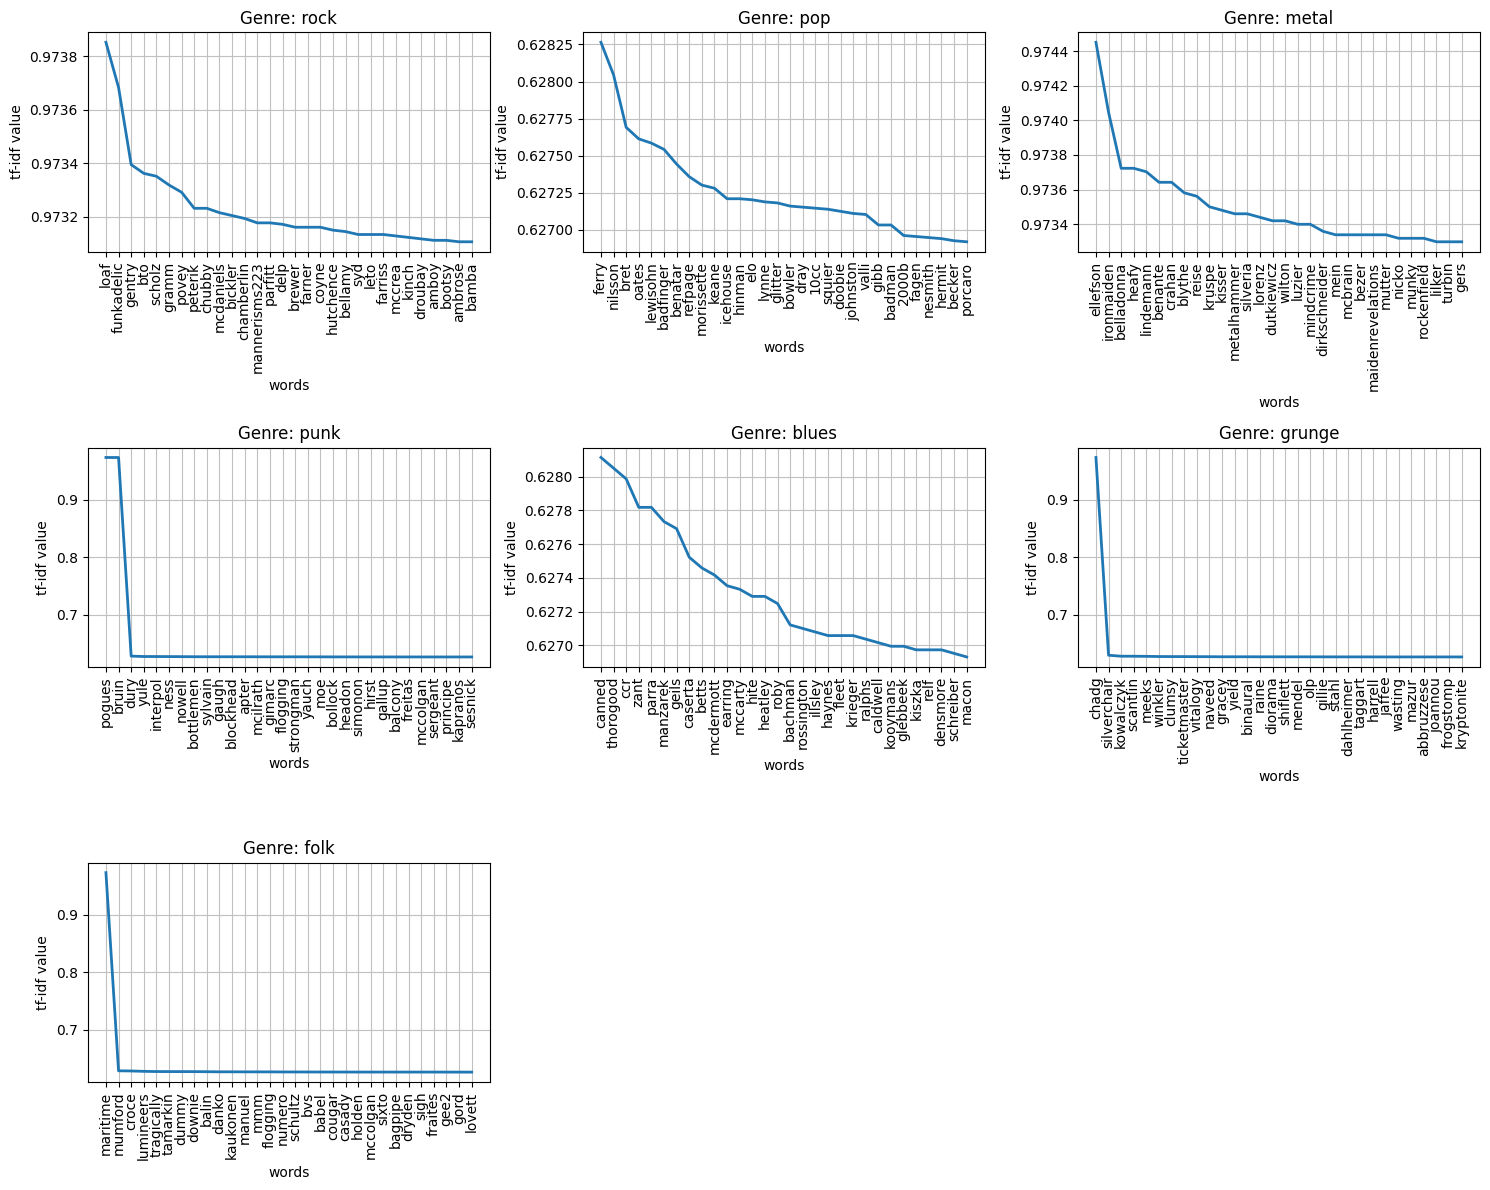

In [17]:
genre_freq_dist = {}
for genre in g:
    text = ""
    for node in performer_genre_dict:
        genres = performer_genre_dict[node]
        
        if genre in genres:
            _,wikitext = wiki_query(node)
            text += wikitext
    genre_freq_dist[genre] = get_clear_freq_dist(text)

genre_tf_idf_dist = get_tf_idf(genre_freq_dist,"Genre")

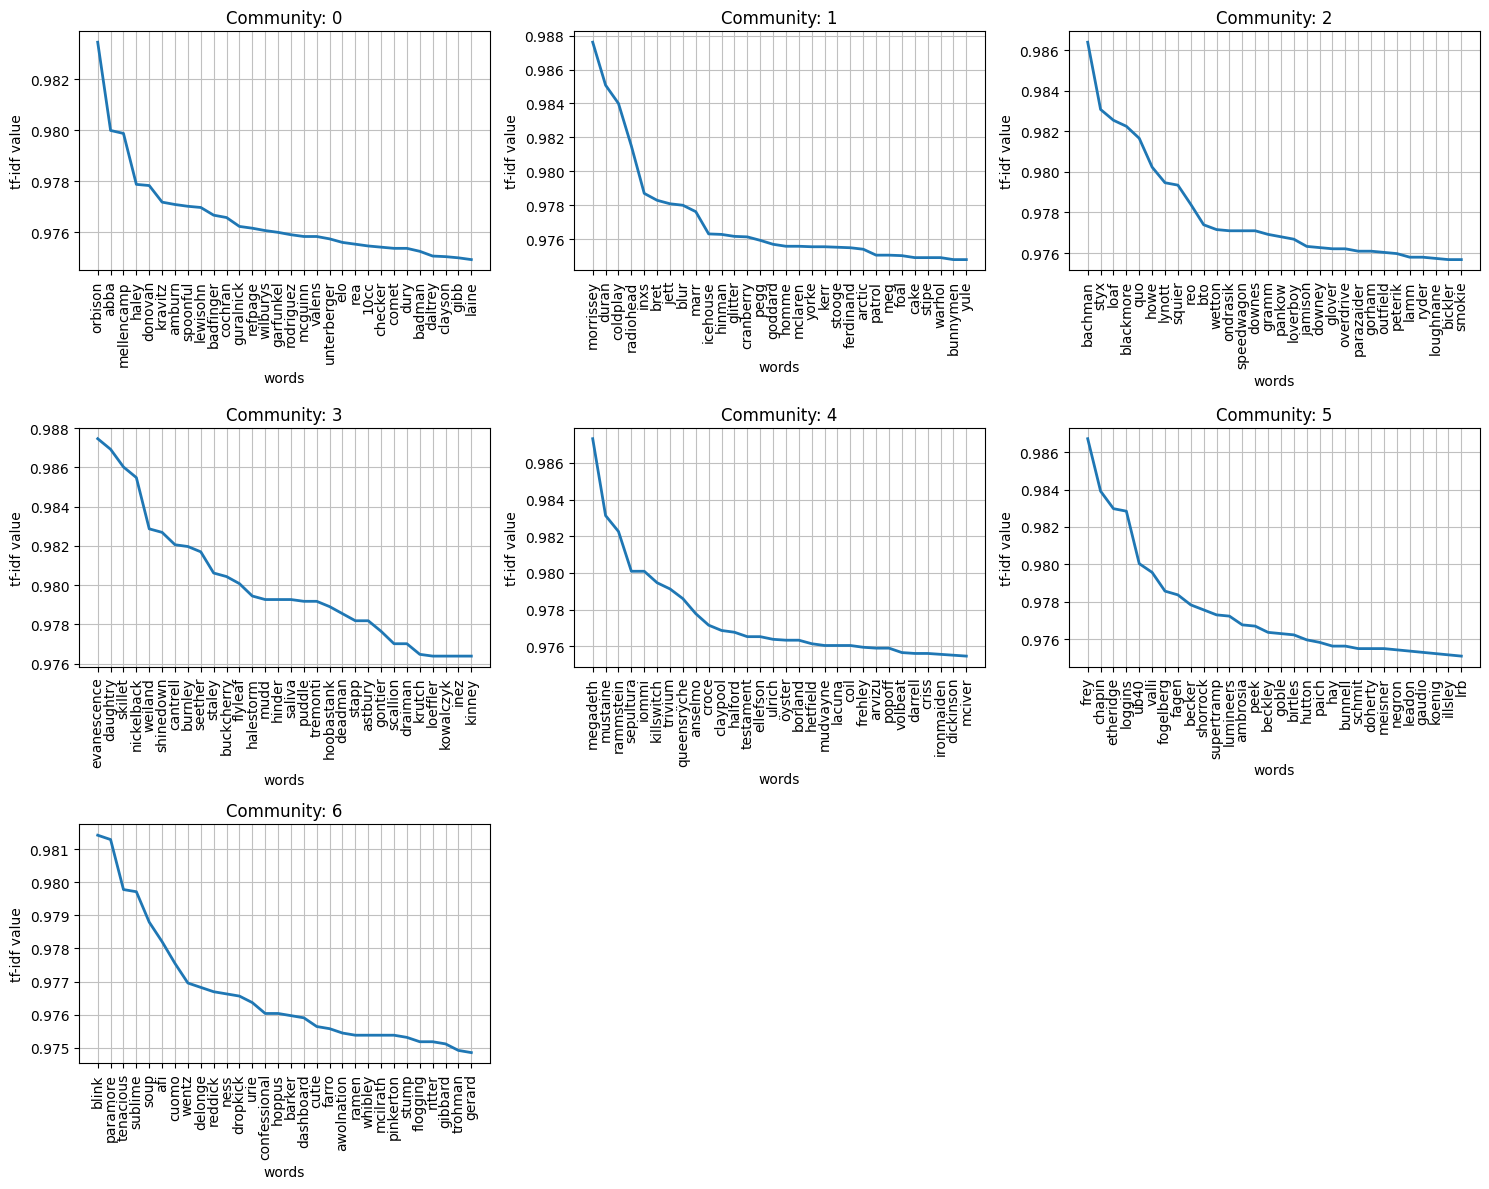

In [18]:
community_freq_dist = {}
for i,community in enumerate(c):
    text = ""
    for node in community:
        _,wikitext = wiki_query(node)
        text += wikitext

    community_freq_dist[i] = get_clear_freq_dist(text)

community_tf_idf_dist = get_tf_idf(community_freq_dist,"Community")

* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.
>
> The matrix D provides a quantitative link between genres and structural communities. Some genres are distributed across multiple communities; conversely, some communities contain multiple genres. The genre word cloud corresponds to the theme of the genre text, while the community word cloud is more mixed, combining keywords from multiple themes. This suggests that structural communities do not reflect pure semantic similarity, but rather a mixture of relationships, such as cross-genre collaboration. This is manifested in matrix D as a multi-peak pattern in the corresponding rows and columns.

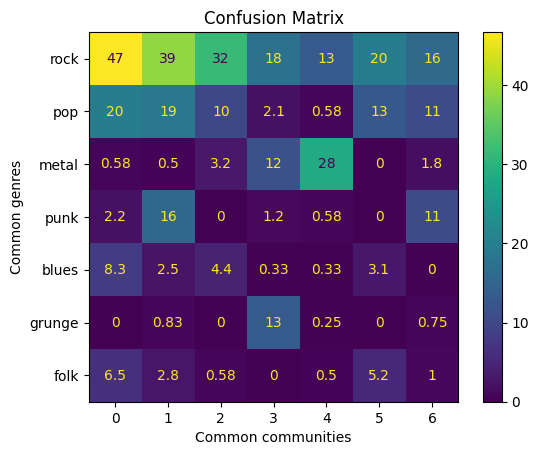

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=d)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Common communities')
plt.ylabel('Common genres')
plt.xticks(range(len(c)),range(0,len(c)))
plt.yticks(range(len(g)),g)
plt.show()

In [20]:
def show_word_clouds(document_tf_idf_dist,title=None,cols = 3):

    rows = math.ceil(len(document_tf_idf_dist) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, document in enumerate(document_tf_idf_dist):
        tf_idf_dist = document_tf_idf_dist[document]
        tf_idf_dict_values = set(tf_idf_dist.values())
        tf_idf_dict_values.remove(0)
        min_tf_idf = min(tf_idf_dict_values)

        tf_idf_text = " ".join([word for word, tf_idf in tf_idf_dist.items() for _ in range(round(tf_idf/min_tf_idf)+1)])
        document_wc = WordCloud(width=800, height=400, background_color='white',collocations=False).generate(tf_idf_text)
        axes[i].imshow(document_wc)
        axes[i].set_title("{}: {} word-cloud".format(title,document))

    for j in range(len(document_tf_idf_dist), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

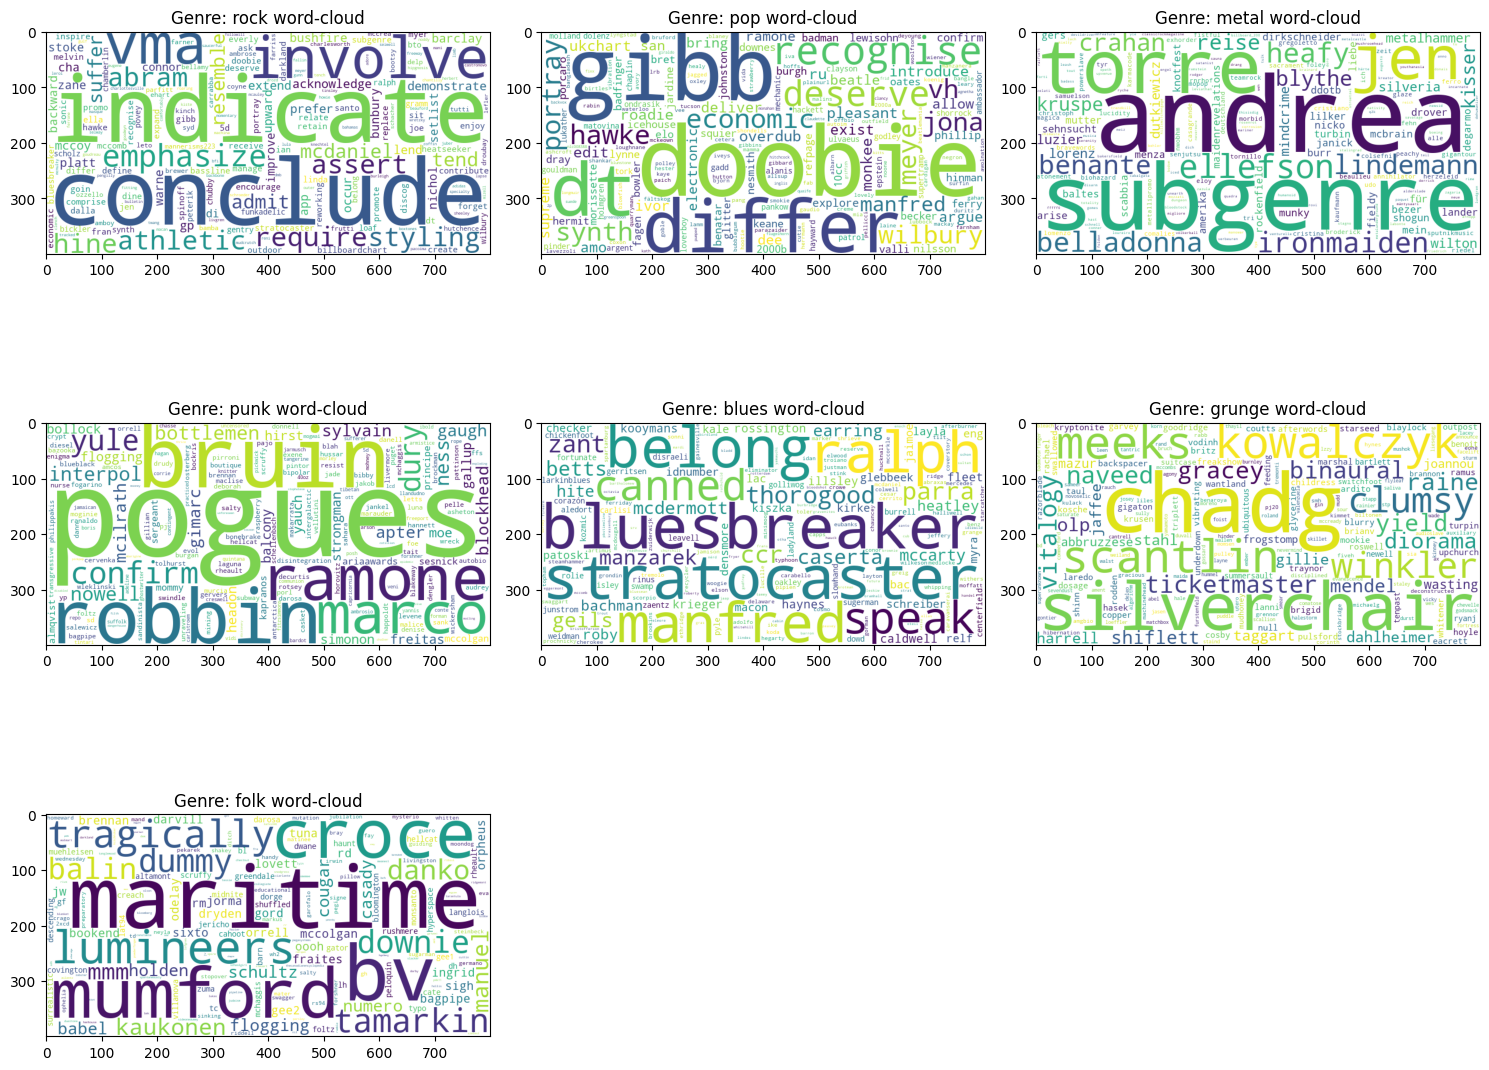

In [21]:
show_word_clouds(genre_tf_idf_dist,"Genre")

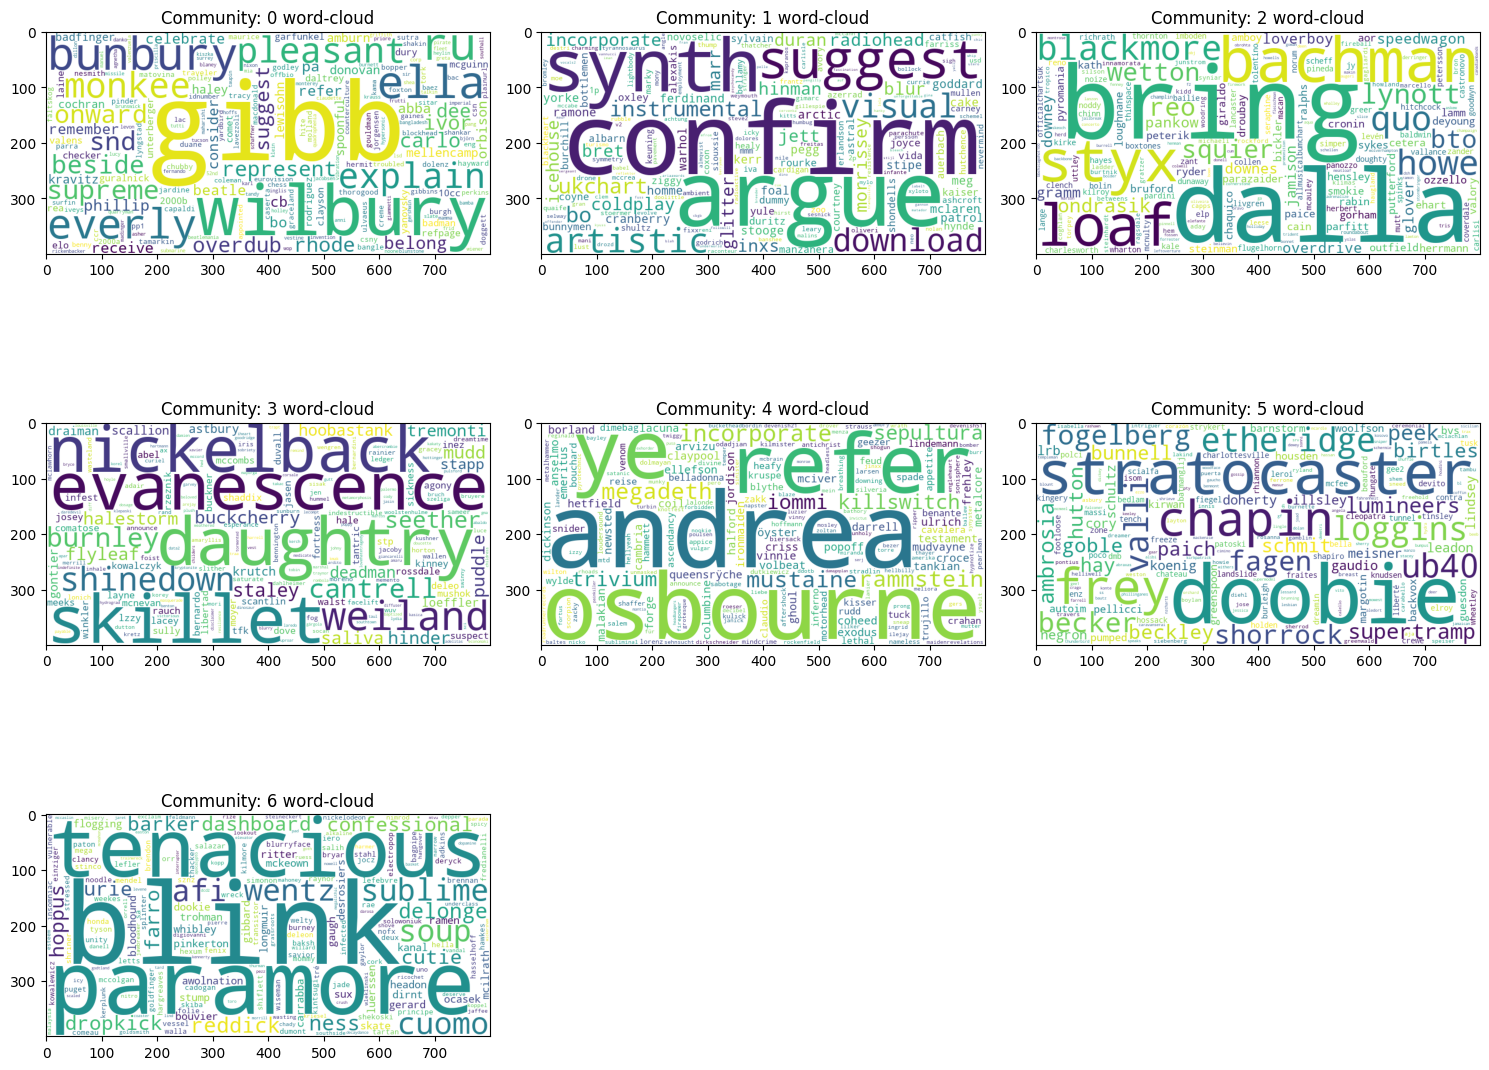

In [22]:
show_word_clouds(community_tf_idf_dist,"Community")

# Part 4: Sentiment of the artists and communities

In [23]:
s1_url = "https://www.student.dtu.dk/~s230357/02805/assignment2/labMT-english.csv"

s1_dataset = pd.read_csv(BytesIO(load_online_data(s1_url)))
labmt_dict = dict(zip(s1_dataset['word'], s1_dataset['sentiment']))

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>
> I found that most wikipedia pages have neutral emotion and a bit more positive, the median, 25th percentile and 75th percentile illustrates this point. I think the main reason is wikipedia needs to maintain an objective stance and avoid being overly emotional or misleading to readers.

Top 10 happiest artists: ['Tracy_Chapman', 'Lenny_Kravitz', 'Michael_Martin_Murphey', 'Edgar_Winter', 'The_Cardigans', 'Boys_Like_Girls', 'Kenny_Loggins', 'The_Boxtones', 'Fun_(band)', 'Kaiser_Chiefs']
Top 10 saddest artists: ['Five_Finger_Death_Punch', 'Pantera', 'W.A.S.P._(band)', 'Skid_Row_(American_band)', 'Ted_Nugent', 'Rob_Zombie', 'Marilyn_Manson', 'Canned_Heat', 'Gary_Glitter', 'Rage_Against_the_Machine']


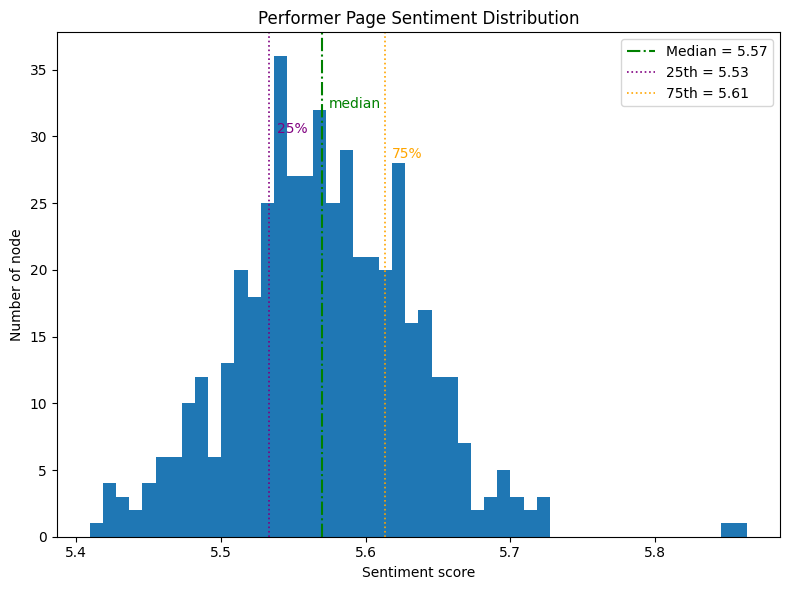

In [24]:
def get_sentiment(text):
    words = nomarralize_words(text)
    sentiments = [labmt_dict[w] for w in words if w in labmt_dict]
    return float(np.mean(sentiments))

artist_sentiment_dict = {node:get_sentiment(wiki_query(node)[1]) for node in rp_ug_net.nodes}

nx.set_node_attributes(rp_ug_net, {node:{"sentiment":artist_sentiment_dict[node]} for node in rp_ug_net.nodes})

sorted_artist_sentiments = sorted(artist_sentiment_dict,key=artist_sentiment_dict.get, reverse=True)

print("Top 10 happiest artists: {}".format(sorted_artist_sentiments[0:10]))
print("Top 10 saddest artists: {}".format(sorted_artist_sentiments[-10:]))

median = np.median(list(artist_sentiment_dict.values()))
variance = np.var(list(artist_sentiment_dict.values()))
p25 = np.percentile(list(artist_sentiment_dict.values()), 25)
p75 = np.percentile(list(artist_sentiment_dict.values()), 75)

plt.figure(figsize=(8, 6))
plt.hist(artist_sentiment_dict.values(), bins=50)

plt.title("Performer Page Sentiment Distribution")
plt.xlabel("Sentiment score")
plt.ylabel("Number of node")

plt.axvline(median, color='green', linestyle='-.', linewidth=1.5, label=f'Median = {median:.2f}')
plt.axvline(p25, color='purple', linestyle=':', linewidth=1.2, label=f'25th = {p25:.2f}')
plt.axvline(p75, color='orange', linestyle=':', linewidth=1.2, label=f'75th = {p75:.2f}')

plt.text(median+0.005, plt.ylim()[1]*0.85, 'median', color='green')
plt.text(p25+0.005, plt.ylim()[1]*0.8, '25%', color='purple')
plt.text(p75+0.005, plt.ylim()[1]*0.75, '75%', color='orange')

plt.legend()
plt.tight_layout()
plt.show()

* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?
> Overall, there was very little variation in sentiment across the communties, I think primarily due to the fact that wikipedia pages are meant to be written in a neutral tone. I used TF-IDF value to weight the communty sentiment calculation, because of the differet value between words, the weighted communty sentiment lower a little bit with the unweighted one, but the overall changes was not significant.

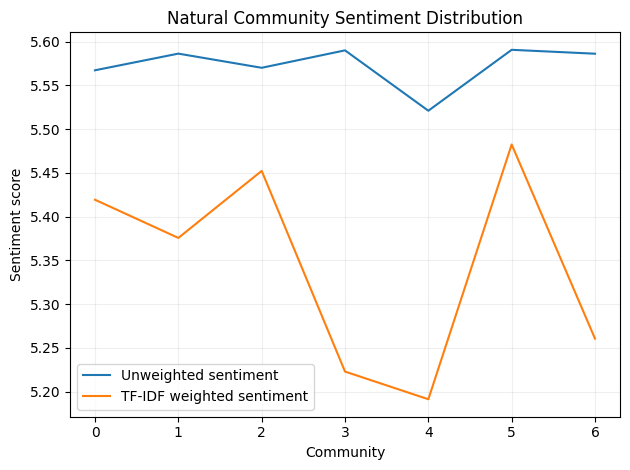

In [25]:
community_normal_sentiment = []

for community in c:
    community_normal_sentiment.append(float(np.mean([s for n,s in rp_ug_net.nodes.data('sentiment') if n in community])))
    
community_tf_idf_sentiment = []

for i,community in enumerate(c):
    tf_idf_dist = community_tf_idf_dist[i]
    avg_tf_idf = np.mean([tf_idf_dist[w] for w in tf_idf_dist if w in labmt_dict])
    community_tf_idf_sentiment.append(float(np.mean([tf_idf_dist[w]*labmt_dict[w] for w in tf_idf_dist if w in labmt_dict])/avg_tf_idf))

plt.plot(range(len(community_normal_sentiment)),community_normal_sentiment,label="Unweighted sentiment")
plt.plot(range(len(community_tf_idf_sentiment)),community_tf_idf_sentiment,label="TF-IDF weighted sentiment")
plt.title('Natural Community Sentiment Distribution')
plt.xlabel('Community')
plt.ylabel('Sentiment score')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
    
plt.tight_layout()
plt.show()